# Setup

In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from pytorch.pytorch_classifier import PyTorchClassifier

from helper_functions import model_eval, feature_rank

import shap
import functools

from sklearnex import patch_sklearn
patch_sklearn()

def save_feature_rank(shap_vals, name):
    feature_rank(shap_vals, name).to_csv(f"feature_ranks/rank_{name}.csv")
    return

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Drop most common categories
dropcols = ['F', 'Other', 'ENGLISH', 'MARRIED', 'WHITE/EUROPEAN']

# One-hot encode categorical variables and standardize continuous variables
onehot_scale = ColumnTransformer([
    ('continuous_scale', StandardScaler(), make_column_selector(dtype_include=['float64'])),
    ('categorical_onehot', OneHotEncoder(drop=dropcols, sparse_output=False, dtype=np.int8), make_column_selector(dtype_include=['category'])),
    ], remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

# Only one-hot encode categorical variables
onehot = ColumnTransformer([
    ('categorical_onehot', OneHotEncoder(drop=dropcols, sparse_output=False, dtype=np.int8), make_column_selector(dtype_include=['category'])),
    ], remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

In [3]:
data = pd.read_parquet("dataset/mimic4-hosp_hf-imputed_0.parquet") 

cont_vars = data.dtypes[data.dtypes == "float64"].index
cat_vars = data.dtypes[data.dtypes != "float64"][:5].index
binary_vars = data.dtypes[data.dtypes != "float64"][5:].index

data[binary_vars] = data[binary_vars].astype(pd.Int8Dtype())


X_train, X_test, y_train, y_test = train_test_split(
    data.drop('heart_failure', axis=1), 
    data['heart_failure'], 
    test_size=0.2, 
    random_state=100
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100)

In [4]:
X_train = onehot.fit_transform(X_train)
X_val = onehot.transform(X_val)
X_test = onehot.transform(X_test)

X_train_scale = onehot_scale.fit_transform(X_train)
X_val_scale = onehot_scale.transform(X_val)
X_test_scale = onehot_scale.transform(X_test)

In [54]:
from imblearn.over_sampling import RandomOverSampler

X_resampled, y_resampled = RandomOverSampler(random_state=100).fit_resample(X_train, y_train)

# Modelling

## Gradient Boosted Trees

In [5]:
model_xgb = xgb.XGBClassifier(random_state=100, max_delta_step=0.5, scale_pos_weight=10).fit(X_train, y_train)

In [6]:
model_eval(model_xgb, X_val, y_val)

{'roc_auc': 0.9349792626113833,
 'roc_auc_ci': array([0.92985291, 0.94010562]),
 'brier': 0.1043780403824647,
 'brier_ci': array([0.10070408, 0.1082238 ]),
 'sensitivity': 0.8737221888153939,
 'sensitivity_ci': array([0.8577578 , 0.88968657]),
 'specificity': 0.8528422863398233,
 'specificity_ci': array([0.84670247, 0.85898211])}

## Logistic Regression

In [5]:
model_lr = LogisticRegression(penalty=None, max_iter=500, class_weight="balanced", random_state=100).fit(X_train, y_train)

c:\Users\Winston\ml\.pixi\envs\default\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
model_eval(model_lr, X_val, y_val)

{'roc_auc': 0.9310269597571612,
 'roc_auc_ci': array([0.92585083, 0.93620309]),
 'brier': 0.10715127373001676,
 'brier_ci': array([0.10361094, 0.11064765]),
 'sensitivity': 0.8713168971737824,
 'sensitivity_ci': array([0.85522339, 0.88741041]),
 'specificity': 0.8515130190007038,
 'specificity_ci': array([0.84535034, 0.8576757 ]),
 'ppv': 0.4327956989247312,
 'ppv_ci': array([0.42420871, 0.44138269]),
 'npv': 0.9807276657060519,
 'npv_ci': array([0.97834496, 0.98311038])}

## Linear Discriminant Analysis

In [55]:
model_lda = LinearDiscriminantAnalysis().fit(X_resampled, y_resampled)

In [56]:
model_eval(model_lda, X_val, y_val)

{'roc_auc': 0.9336678153819706,
 'roc_auc_ci': array([0.92850897, 0.93882666]),
 'brier': 0.10882368460927533,
 'brier_ci': array([0.10478298, 0.11293352]),
 'sensitivity': 0.8731208659049909,
 'sensitivity_ci': array([0.85712402, 0.88911771]),
 'specificity': 0.8522167487684729,
 'specificity_ci': array([0.84606615, 0.85836735])}

## Neural Network

In [15]:
model_nn = PyTorchClassifier((32, 16, 8), 
                             epochs=50, 
                             batch_size=8192, 
                             random_state=100, 
                             verbose=False, 
                             device='cuda'
                             ).fit(X_resampled, y_resampled)

In [16]:
model_eval(model_nn, X_val_scale, y_val)

{'roc_auc': 0.9385088198023454,
 'roc_auc_ci': array([0.93351433, 0.94350331]),
 'brier': 0.1052988063606043,
 'brier_ci': array([0.10166608, 0.10893453]),
 'sensitivity': 0.8881539386650631,
 'sensitivity_ci': array([0.8730059 , 0.90330198]),
 'specificity': 0.8372038470560638,
 'specificity_ci': array([0.8308055 , 0.84360219])}

## SVM

In [17]:
model_svm = CalibratedClassifierCV(LinearSVC(random_state=100)).fit(X_resampled, y_resampled)
model_eval(model_svm, X_val_scale, y_val)

{'roc_auc': 0.9354969861680685,
 'roc_auc_ci': array([0.93036807, 0.94062591]),
 'brier': 0.10202075151138981,
 'brier_ci': array([0.09854568, 0.10569227]),
 'sensitivity': 0.8743235117257967,
 'sensitivity_ci': array([0.8583917 , 0.89025532]),
 'specificity': 0.8576120103213699,
 'specificity_ci': array([0.85155565, 0.86366837])}

## Decision Tree

In [102]:
model_dt = DecisionTreeClassifier(random_state=100, class_weight='balanced', max_depth=10).fit(X_train, y_train)
model_eval(model_dt, X_val, y_val)

{'roc_auc': 0.8959005143241006,
 'roc_auc_ci': array([0.88565185, 0.90614917]),
 'brier': 0.10769678176658909,
 'brier_ci': array([0.10401478, 0.11157793]),
 'sensitivity': 0.8460613349368611,
 'sensitivity_ci': array([0.82871624, 0.86340643]),
 'specificity': 0.850261943858003,
 'specificity_ci': array([0.8440779 , 0.85644598])}

## Random Forest

In [5]:
model_rf = RandomForestClassifier(random_state=100, class_weight="balanced", max_depth=10).fit(X_train, y_train)
model_eval(model_rf, X_val, y_val)

{'roc_auc': 0.9330809272306182,
 'roc_auc_ci': array([0.92806054, 0.93810131]),
 'brier': 0.09991585071027693,
 'brier_ci': array([0.09704849, 0.10294405]),
 'sensitivity': 0.867708959711365,
 'sensitivity_ci': array([0.85142522, 0.8839927 ]),
 'specificity': 0.8521385565720541,
 'specificity_ci': array([0.84598661, 0.8582905 ])}

## Naive Bayes

In [57]:
model_nb = GaussianNB().fit(X_resampled, y_resampled)
model_eval(model_nb, X_val, y_val)

{'roc_auc': 0.8950446318518146,
 'roc_auc_ci': array([0.88839016, 0.90169911]),
 'brier': 0.15591285850660966,
 'brier_ci': array([0.14998082, 0.16153763]),
 'sensitivity': 0.7690920024052916,
 'sensitivity_ci': array([0.74883801, 0.78934599]),
 'specificity': 0.8433810305731488,
 'specificity_ci': array([0.83708214, 0.84967992])}

# SHAP

In [97]:
explainers_xgb = shap.GPUTreeExplainer(model_xgb, X_train.astype('float64'))
shap_xgb = explainers_xgb(X_val)
save_feature_rank(shap_xgb, "gbt")

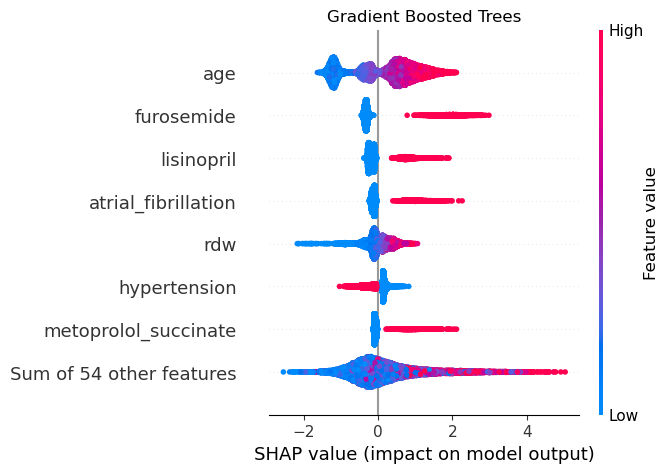

In [99]:
shap.plots.beeswarm(shap_xgb, max_display=8, plot_size=(5,5), show=False)
plt.title("Gradient Boosted Trees")
plt.show()

In [7]:
explainer_lr = shap.LinearExplainer(model_lr, X_train.astype('float64'))
shap_lr = explainer_lr(X_val.astype('float64'))
save_feature_rank(shap_lr, "lr")

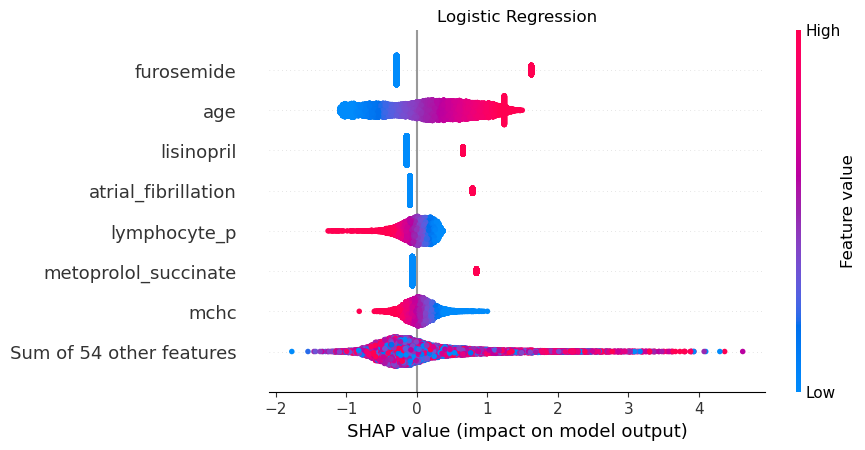

In [8]:
shap_lr.values = shap_lr.values.astype('float64')
shap.plots.beeswarm(shap_lr, max_display=8, show=False)
plt.title("Logistic Regression")
plt.show()

In [63]:
o = 22
print(y_val.reset_index(drop=True)[o])
print(model_lr.predict(X_val.reset_index(drop=True).iloc[[o]].astype('float64')))
print(model_lr.predict_proba(X_val.reset_index(drop=True).iloc[[o]].astype('float64')))

0
[0.]
[[0.96915726 0.03084274]]


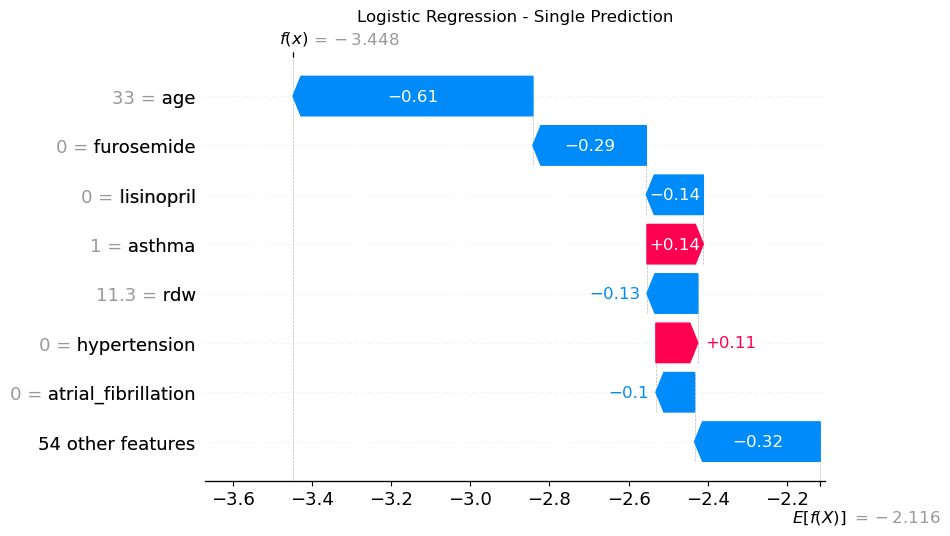

In [64]:
shap.plots.waterfall(shap_lr[o], max_display=8, show=False)
plt.title("Logistic Regression - Single Prediction")
plt.show()

In [103]:
explainers_dt = shap.GPUTreeExplainer(model_dt, X_train.astype('float64'))
shap_dt = explainers_dt(X_val)
save_feature_rank(shap_dt, "dt")

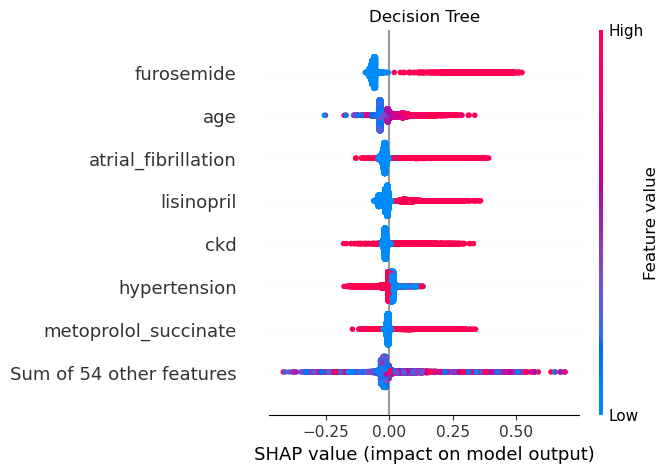

In [107]:
shap_dt1 = shap.Explanation(values=shap_dt.values[:,:,1].astype('float64'),
                            base_values=shap_dt.base_values,
                            data=X_val.astype('float64'),
                            feature_names=X_val.columns)
shap.plots.beeswarm(shap_dt1, max_display=8, plot_size=(5,5), show=False)
plt.title("Decision Tree")
plt.show()

In [6]:
explainers_rf = shap.GPUTreeExplainer(model_rf, X_train.astype('float64'))
shap_rf = explainers_rf(X_val)
save_feature_rank(shap_rf, "rf")

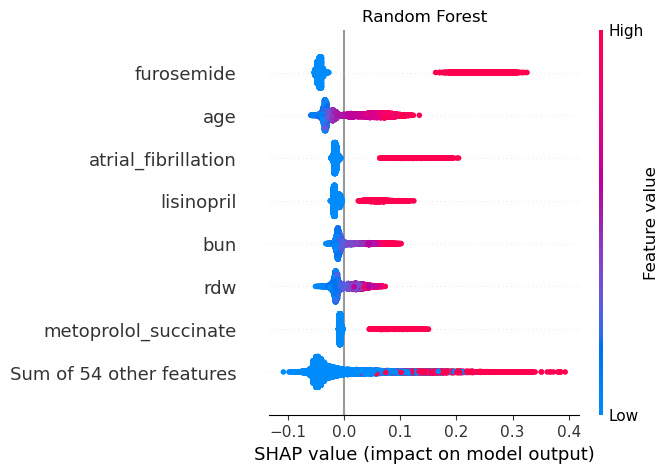

In [7]:
shap_rf1 = shap.Explanation(values=shap_rf.values[:,:,1].astype('float64'),
                            base_values=shap_rf.base_values,
                            data=X_val.astype('float64'),
                            feature_names=X_val.columns)
shap.plots.beeswarm(shap_rf1, max_display=8, plot_size=(5,5), show=False)
plt.title("Random Forest")
plt.show()

# Mean Feature Rankings

In [16]:
nn = pl.DataFrame(pd.read_csv("feature_ranks/mi_nn.csv", index_col=0)[["nn0"]].reset_index().rename(columns={"index": ""}))
svm = pl.DataFrame(pd.read_csv("feature_ranks/mi_svm.csv", index_col=0)[["svm0"]].reset_index().rename(columns={"index": ""}))
dt = pl.read_csv("feature_ranks/rank_dt.csv")
rf = pl.read_csv("feature_ranks/rank_rf.csv")
gbt = pl.read_csv("feature_ranks/rank_gbt.csv")
lr = pl.read_csv("feature_ranks/rank_lr.csv")

In [17]:
results = dt
for n in [gbt, lr, nn, rf, svm]:
    results = results.join(n, on=pl.col(""))

In [18]:
results

,dt,gbt,lr,nn0,rf,svm0
str,f64,f64,f64,f64,f64,f64
"""furosemide""",1.0,2.0,1.0,1.0,1.0,1.0
"""age""",2.0,1.0,2.0,2.0,2.0,2.0
"""hypertension""",6.0,6.0,10.0,11.0,13.0,3.0
"""atrial_fibrillation""",3.0,4.0,4.0,4.0,3.0,4.0
"""lisinopril""",4.0,3.0,3.0,3.0,4.0,5.0
…,…,…,…,…,…,…
"""ast""",24.0,28.0,54.0,38.0,31.0,57.0
"""race_OTHER""",56.0,54.0,52.0,44.0,45.0,56.0
"""diabetes_type_1""",46.0,59.0,57.0,58.0,58.0,60.0


In [19]:
feature_rank_all = results.with_columns(
    mean=pl.mean_horizontal(cs.all())
).sort(
    'mean'
).rename(
    lambda x: x[:-1] if x[-1:] == '0' else x
)

feature_rank_all

,dt,gbt,lr,nn,rf,svm,mean
str,f64,f64,f64,f64,f64,f64,f64
"""furosemide""",1.0,2.0,1.0,1.0,1.0,1.0,1.166667
"""age""",2.0,1.0,2.0,2.0,2.0,2.0,1.833333
"""atrial_fibrillation""",3.0,4.0,4.0,4.0,3.0,4.0,3.666667
"""lisinopril""",4.0,3.0,3.0,3.0,4.0,5.0,3.666667
"""metoprolol_succinate""",7.0,7.0,6.0,8.0,7.0,6.0,6.833333
…,…,…,…,…,…,…,…
"""rivaroxaban""",54.0,56.0,49.0,59.0,57.0,54.0,54.833333
"""diabetes_type_1""",46.0,59.0,57.0,58.0,58.0,60.0,56.333333
"""ramipril""",53.0,58.0,59.0,60.0,59.0,55.0,57.333333


In [20]:
feature_rank_all = feature_rank_all.with_columns(pl.col('mean').round(3))
feature_rank_all.write_csv('tables/feature_ranks_summary0.csv')

In [3]:
feature_rank_all = pl.read_csv('tables/feature_ranks_summary0.csv')

In [4]:
# Replace one-hot encoded feature names with original feature name
vars_ordered = feature_rank_all.to_series(0).str.replace(r"(\w+)_\p{Uppercase}.*", r"${1}")

# Top features
top_10 = vars_ordered.filter(vars_ordered.is_first_distinct()).to_list()[:10]
top_10

['furosemide',
 'age',
 'atrial_fibrillation',
 'lisinopril',
 'metoprolol_succinate',
 'hypertension',
 'rdw',
 'bun',
 'ckd',
 'carvedilol']

# Smaller Model

In [5]:
top_10 = ['furosemide',
 'age',
 'atrial_fibrillation',
 'lisinopril',
 'metoprolol_succinate',
 'hypertension',
 'rdw',
 'bun',
 'ckd',
 'carvedilol']

top_9 = ['furosemide',
 'age',
 'atrial_fibrillation',
 'lisinopril',
 'metoprolol_succinate',
 'rdw',
 'bun',
 'ckd',
 'carvedilol']

In [6]:
import copy
import warnings
def bootstrap_coef(model, X, y, repeats=1000, conf_level=0.95, seed=100):
    """
    Get a confidence interval for the coefficients of a linear model using bootstrapping.
    
    Example: `bootstrap_coef(LogisticRegression(random_state=123), X, y)`

    ## Parameters
        model: sklearn model
            This does not need to be fitted. The bootstrapping process will make a copy of the model and will not alter the original.

        X: array-like

        y: array-like

        repeats: int, default=100
            Number of times we generate bootstrap samples and train the model.
        
        conf_level: float, default=0.95
            Confidence level for the confidence interval. Should be a float between 0 and 1.
        
        seed: int, default=100
            Random seed used to generate bootstrap samples. Note: this does not affect the model's random_state. 
            For reproducibility, the model's random_state must be specified separately.
    
    ## Returns
        scores: dict
            Dictionary of the metrics and their confidence intervals.
    """
    rng = np.random.default_rng(seed)
    m = copy.deepcopy(model)
    percentiles = [100*(1-conf_level)/2, 100*(1+conf_level)/2]

    coefs = np.empty((repeats, X.shape[1]))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for n in range(repeats):
            # Create bootstrap sample
            train_idx = rng.integers(X.shape[0], size=X.shape[0])
            
            # Fit model on bootstrap training sample
            m.fit(X.iloc[train_idx], y.iloc[train_idx])

            coefs[n] = m.coef_

    coefs = np.transpose(coefs)

    def get_percentiles(a):
        return np.percentile(a, percentiles)

    ci = np.apply_along_axis(get_percentiles, 1, coefs)
    ci_df = pd.DataFrame(ci, columns=['ci_lower', 'ci_upper'], index=X.columns)

    return ci_df

In [7]:
smaller_xgb = xgb.XGBClassifier(random_state=100, max_delta_step=0.5, scale_pos_weight=10).fit(X_train[top_10], y_train)
model_eval(smaller_xgb, X_test[top_10], y_test)

{'roc_auc': 0.9341221616284768,
 'roc_auc_ci': array([0.93082439, 0.93741993]),
 'brier': 0.1156475631283416,
 'brier_ci': array([0.11331994, 0.11806775]),
 'sensitivity': 0.8911714355588163,
 'sensitivity_ci': array([0.88162609, 0.90071678]),
 'specificity': 0.8286151253160211,
 'specificity_ci': array([0.82448873, 0.83274152]),
 'ppv': 0.39890530925013684,
 'ppv_ci': array([0.39354346, 0.40426716]),
 'npv': 0.9835142444337421,
 'npv_ci': array([0.98211995, 0.98490854])}

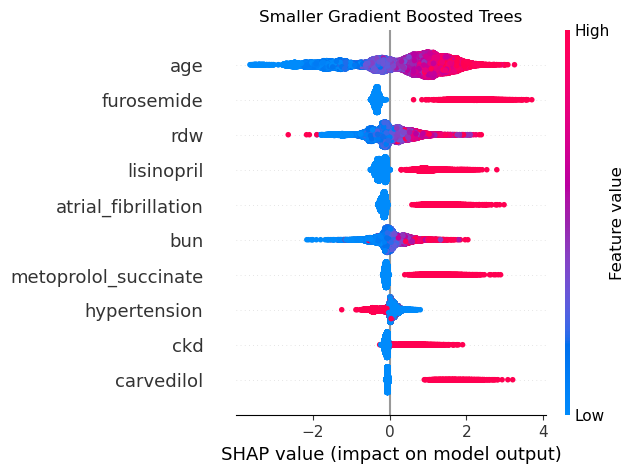

In [9]:
explainers_xgb = shap.GPUTreeExplainer(smaller_xgb, X_train[top_10].astype('float64'))
shap_xgb = explainers_xgb(X_test[top_10])
shap.plots.beeswarm(shap_xgb, max_display=10, plot_size=(5,5), show=False)
plt.title("Smaller Gradient Boosted Trees")
plt.show()

In [10]:
smaller_lr = LogisticRegression(penalty=None, class_weight='balanced', random_state=100).fit(X_train[top_10], y_train)
model_eval(smaller_lr, X_test[top_10], y_test)

c:\Users\Winston\ml\.pixi\envs\default\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'roc_auc': 0.9323648878009408,
 'roc_auc_ci': array([0.92903336, 0.93569642]),
 'brier': 0.10620687818120268,
 'brier_ci': array([0.10394156, 0.10837548]),
 'sensitivity': 0.8672046955245781,
 'sensitivity_ci': array([0.8568033 , 0.87760609]),
 'specificity': 0.8513998564249821,
 'specificity_ci': array([0.84750506, 0.85529466]),
 'ppv': 0.4268689057421452,
 'ppv_ci': array([0.42145285, 0.43228496]),
 'npv': 0.980482369433162,
 'npv_ci': array([0.97896762, 0.98199712])}

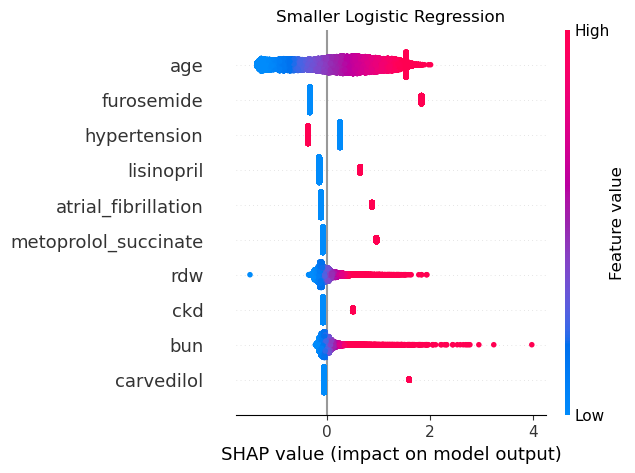

In [11]:
explainer_lr = shap.LinearExplainer(smaller_lr, X_train[top_10].astype('float64'))
shap_lr = explainer_lr(X_test[top_10].astype('float64'))
shap_lr.values = shap_lr.values.astype('float64')
shap.plots.beeswarm(shap_lr, max_display=10, plot_size=(5,5), show=False)
plt.title("Smaller Logistic Regression")
plt.show()

In [67]:
logreg_coef_ci = bootstrap_coef(LogisticRegression(penalty=None, class_weight='balanced', random_state=100),
                                X_train[top_10], y_train, repeats=1000)
logreg_coef_ci2 = pd.concat([pd.Series(smaller_lr.coef_[0], index=top_10, name = 'coef'), logreg_coef_ci], axis=1)

In [69]:
logreg_coef_ci2

,coef,ci_lower,ci_upper
furosemide,2.161445,2.039663,2.288717
age,0.039503,0.033732,0.042145
atrial_fibrillation,0.988260,0.872710,1.198531
lisinopril,0.792647,0.596405,0.820903
metoprolol_succinate,1.037411,0.987646,1.198832
hypertension,-0.618561,-0.709710,-0.502154
rdw,0.105104,0.054354,0.117598
bun,0.014440,0.012381,0.017529
ckd,0.581468,0.457550,0.630651
carvedilol,1.645644,1.562114,2.365758


In [77]:

pl.DataFrame(
    logreg_coef_ci2.reset_index(names="Predictor")
).select(pl.col("Predictor"), 
         cs.numeric().exp().round(3)
).rename(
    {"coef": "OR",
     "ci_lower": "95% CI Lower",
     "ci_upper": "95% CI Upper"
}
).write_csv("tables/logreg_or_ci.csv")

### Without Hypertension

In [13]:
smaller_xgb2 = xgb.XGBClassifier(random_state=100, max_delta_step=0.5, scale_pos_weight=10).fit(X_train[top_9], y_train)
model_eval(smaller_xgb2, X_test[top_9], y_test)

{'roc_auc': 0.930602927217792,
 'roc_auc_ci': array([0.92720708, 0.93399878]),
 'brier': 0.11982396976335966,
 'brier_ci': array([0.11756164, 0.12231417]),
 'sensitivity': 0.8963071655661531,
 'sensitivity_ci': array([0.88696296, 0.90565137]),
 'specificity': 0.8215924342207934,
 'specificity_ci': array([0.81740022, 0.82578465]),
 'ppv': 0.390683296023878,
 'ppv_ci': array([0.38534082, 0.39602577]),
 'npv': 0.9841477548883987,
 'npv_ci': array([0.98278008, 0.98551543])}

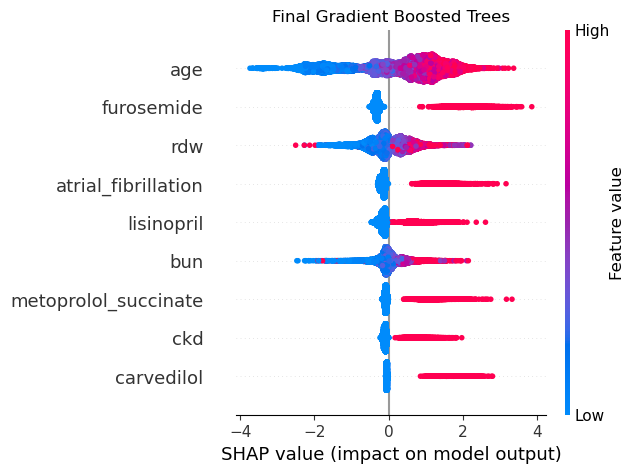

In [14]:
explainers_xgb2 = shap.GPUTreeExplainer(smaller_xgb2, X_train[top_9].astype('float64'))
shap_xgb2 = explainers_xgb2(X_test[top_9])
shap.plots.beeswarm(shap_xgb2, max_display=10, plot_size=(5,5), show=False)
plt.title("Final Gradient Boosted Trees")
plt.show()

In [15]:
smaller_lr2 = LogisticRegression(penalty=None, class_weight='balanced', random_state=100).fit(X_train[top_9], y_train)
model_eval(smaller_lr2, X_test[top_9], y_test)

c:\Users\Winston\ml\.pixi\envs\default\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'roc_auc': 0.9307228898419083,
 'roc_auc_ci': array([0.92741386, 0.93403192]),
 'brier': 0.10846746477566259,
 'brier_ci': array([0.10617712, 0.11065293]),
 'sensitivity': 0.8691611640988016,
 'sensitivity_ci': array([0.85882503, 0.8794973 ]),
 'specificity': 0.8474359374512314,
 'specificity_ci': array([0.84349873, 0.85137314]),
 'ppv': 0.42099028666192845,
 'ppv_ci': array([0.41558414, 0.42639643]),
 'npv': 0.9806761540128585,
 'npv_ci': array([0.97916879, 0.98218352])}

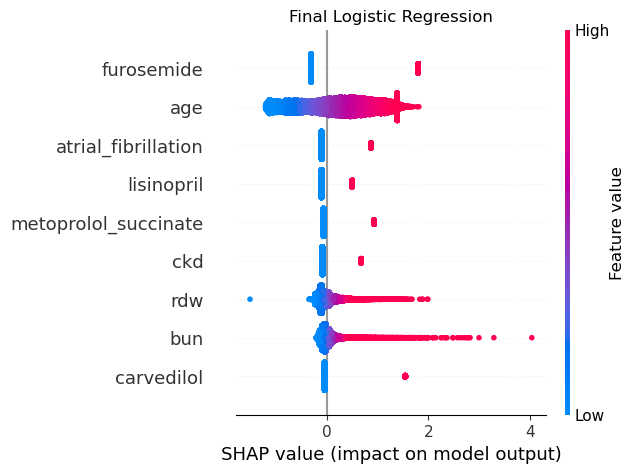

In [16]:
explainer_lr2 = shap.LinearExplainer(smaller_lr2, X_train[top_9].astype('float64'))
shap_lr2 = explainer_lr2(X_test[top_9].astype('float64'))
shap_lr2.values = shap_lr2.values.astype('float64')
shap.plots.beeswarm(shap_lr2, max_display=10, plot_size=(5,5), show=False)
plt.title("Final Logistic Regression")
plt.show()

In [17]:
logreg_coef_ci_2 = bootstrap_coef(LogisticRegression(penalty=None, class_weight='balanced', random_state=100),
                                X_train[top_9], y_train, repeats=1000)
logreg_coef_ci2_2 = pd.concat([pd.Series(smaller_lr2.coef_[0], index=top_9, name = 'coef'), logreg_coef_ci_2], axis=1)

pl.DataFrame(
    logreg_coef_ci2_2.reset_index(names="Predictor")
).select(pl.col("Predictor"), 
         cs.numeric().exp().round(3)
).rename(
    {"coef": "OR",
     "ci_lower": "95% CI Lower",
     "ci_upper": "95% CI Upper"
}
).write_csv("tables/logreg_or_ci_no_hypertension.csv")

In [18]:
logreg_coef_ci2_2

,coef,ci_lower,ci_upper
furosemide,2.113355,2.009231,2.222228
age,0.035524,0.030862,0.037398
atrial_fibrillation,0.974427,0.906917,1.099383
lisinopril,0.605265,0.476299,0.688548
metoprolol_succinate,0.997275,0.924441,1.099423
rdw,0.107654,0.061558,0.118276
bun,0.014677,0.012979,0.018610
ckd,0.764894,0.495051,0.840234
carvedilol,1.591523,1.499549,2.229220


In [20]:
pl.DataFrame(
    logreg_coef_ci2_2.reset_index(names="Predictor")
).select(pl.col("Predictor"), 
         cs.numeric().exp().round(3)
).rename(
    {"coef": "OR",
     "ci_lower": "95% CI Lower",
     "ci_upper": "95% CI Upper"
})

Predictor,OR,95% CI Lower,95% CI Upper
str,f64,f64,f64
"""furosemide""",8.276,7.458,9.228
"""age""",1.036,1.031,1.038
"""atrial_fibrillation""",2.65,2.477,3.002
"""lisinopril""",1.832,1.61,1.991
"""metoprolol_succinate""",2.711,2.52,3.002
"""rdw""",1.114,1.063,1.126
"""bun""",1.015,1.013,1.019
"""ckd""",2.149,1.641,2.317
"""carvedilol""",4.911,4.48,9.293
